The clustering method works slower but more correctly with as large as possible a squiggle

The sequential significant values method works the same with any length squiggle.

In [2]:
import time
from ont_fast5_api.fast5_interface import get_fast5_file
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
def loadReads(f5_file="../../similar_testdata/similar_squiggles.fast5", withMetadata=False):
    '''
        returns list of numpy arrays representing reads as well as dataframe containing reads metadata.
    '''
    print("reading squiggles file...")
    start = time.time()
    reads = []
    if withMetadata:
        ids = []
        length = []
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
                ids.append(read.read_id)
                length.append(len(raw_data))

        z = list(zip(ids, length))
        print(f"Took {time.time()-start} seconds.\n")
        return reads, pd.DataFrame(z, columns=["id", "length"])

    else:
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
        print(f"Took {time.time()-start} seconds.\n")
        return reads

In [4]:
def getClusters(sequence, noOfClusters):
    '''
        calculates n centroids (where n=noOfClusters) around which data is clustered.
    '''

    prevCentroids = [0 for i in range(noOfClusters)]
    centroids = random.sample(sequence, noOfClusters)

    clusters = [[] for i in centroids]
    clustersAggregate = [0 for i in range(noOfClusters)]


    clusterIndex = 0
    distances = [0 for i in range(noOfClusters)]
    done = False

    while not done:
        clusters = [[] for i in centroids]
        clustersAggregate = [0 for i in range(noOfClusters)]
        for component in sequence:
            for i in range(noOfClusters):
                distances[i] = abs(centroids[i] - component)

            clusterIndex = distances.index(min(distances))
            clusters[clusterIndex].append(component)
            clustersAggregate[clusterIndex] += component

        prevCentroids = centroids.copy()
        for i in range(noOfClusters):
            if len(clusters[i]) != 0:
                centroids[i] = clustersAggregate[i]/len(clusters[i])


        if centroids == prevCentroids:
            done = True

    return centroids

In [5]:
def clustNormalise(sequence, noOfClusters, verbose=True):
    '''
        Normalises vector to series of values in range 1-4
    '''
    centroids = getClusters(sequence, noOfClusters)
    centroids.sort()
    if verbose: print(f"centroids: {centroids}")
    normalValues = [i for i in range(1,noOfClusters+1)]
    newSequence = []
    differences = [0 for i in range(noOfClusters)]
    for component in sequence:
        for i in range(noOfClusters):
            differences[i] = abs(centroids[i]-component)

        newSequence.append(normalValues[differences.index(min(differences))])
    
    return np.array(newSequence, dtype=np.byte)

In [6]:
def zScoreNormalise(sequence):
    zScoreNormalised = np.zeros(len(sequence))
    mean = np.mean(sequence)
    standardDev = np.std(sequence)
    zScoreNormalised = (sequence - mean) / standardDev
    return zScoreNormalised

In [7]:
allSquiggles, metadata = loadReads(withMetadata=True)

reading squiggles file...
Took 6.008092164993286 seconds.



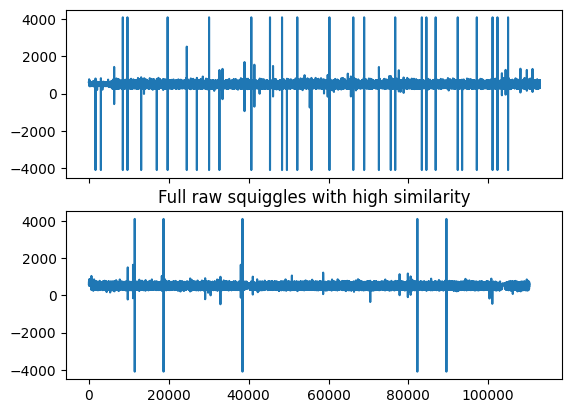

In [8]:
compNo = 2      #no. of squiggles being compared
similarSquiggles = ["995e06ac-fb8c-4c67-a783-223583c215bd", "4d1b87b0-a975-4520-bd89-40e8dd0dd185"]
similarIndices = metadata.index[(metadata['id']==similarSquiggles[0]) | (metadata['id']==similarSquiggles[1])].tolist()

copiedSquiggles = [allSquiggles[similarIndices[i]].copy() for i in range(compNo)]


fig1, axs = plt.subplots(compNo, sharex=True)
plt.title("Full raw squiggles with high similarity")
for i in range(compNo):
    axs[i].plot(copiedSquiggles[i])

plt.show()

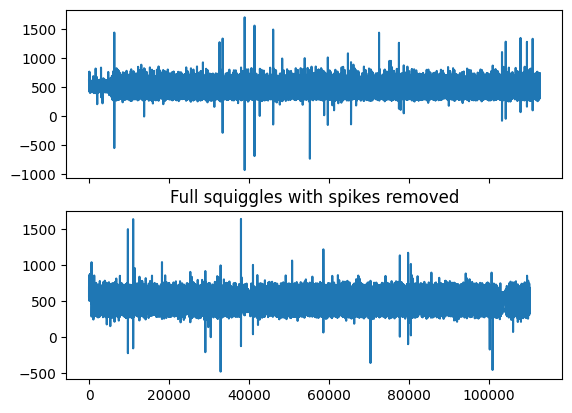

In [9]:
spikeThresh = 2000
removedSpikes = []
for i in range(compNo):
    removedSpikes.append([j for j in copiedSquiggles[i] if abs(j) < spikeThresh])

fig, axs = plt.subplots(compNo, sharex=True)
plt.title("Full squiggles with spikes removed")
for i in range(compNo):
    axs[i].plot(removedSpikes[i])

plt.show()

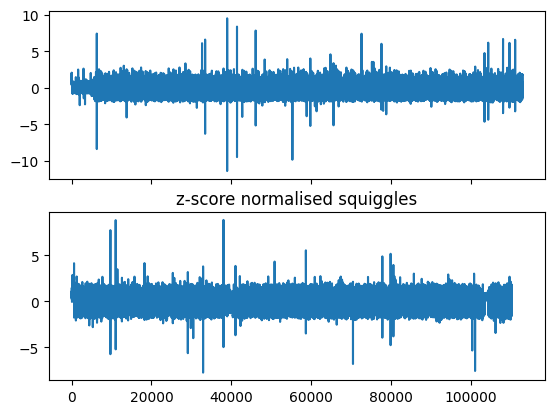

In [10]:
zScoreNormalised = [zScoreNormalise(np.array(i)) for i in removedSpikes]       #list holding the 2 squiggles that have been normalised based on the z-score

fig, axs = plt.subplots(compNo, sharex=True)
plt.title("z-score normalised squiggles")
for i in range(compNo):
    axs[i].plot(zScoreNormalised[i])

plt.show()

# Resolution Reduction

In [14]:
#variables used to control the resolution of the significant values, and clustering approximations, respectively
thresh = 0.15
noOfClusters = 12

## Based on clustering

centroids: [-9.77931688691852, -4.260237209571435, -1.9265140726611942, -1.7549210225826088, -1.6558606303157855, -1.579532280972232, -1.5160857453398175, -1.4689750045546914, -1.43340473567623, -1.4013236731087455, -1.3698236233277796, -1.3381728897103342, -1.3103793970003383, -1.2947193036291207, -1.282873050411468, -1.262764548535125, -1.2392118524445652, -1.2114242414126668, -1.1792627236234254, -1.1524191668512627, -1.1245056141575693, -1.088604232058257, -1.0492451101800726, -1.0098740974828007, -0.9700559263757808, -0.9221089401361132, -0.8592447188963026, -0.785042935739765, -0.7056240536073428, -0.6280412062063501, -0.5614417528459269, -0.5013728219461993, -0.453910254922905, -0.41863173068460424, -0.38268749389126566, -0.3359647255346458, -0.27565469554684024, -0.21209212823341791, -0.14800292214486688, -0.08524089846132718, -0.025939427924707877, 0.02173916631893909, 0.053541765122137715, 0.081094513490271, 0.1168407785969336, 0.16086663196494855, 0.21122829555319178, 0.2668

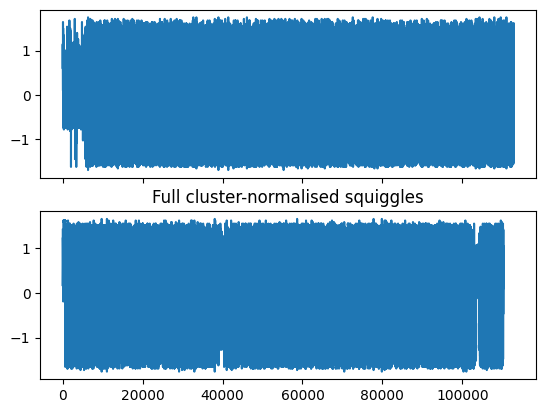

In [15]:
clustered = [clustNormalise(zScoreNormalised[i].tolist(), 99) for i in range(compNo)]

clusteredNormalised = [zScoreNormalise(np.array(i)) for i in clustered]

fig, axs = plt.subplots(compNo, sharex=True)
plt.title("Full cluster-normalised squiggles")
for i in range(compNo):
    axs[i].plot(clusteredNormalised[i])

plt.show()

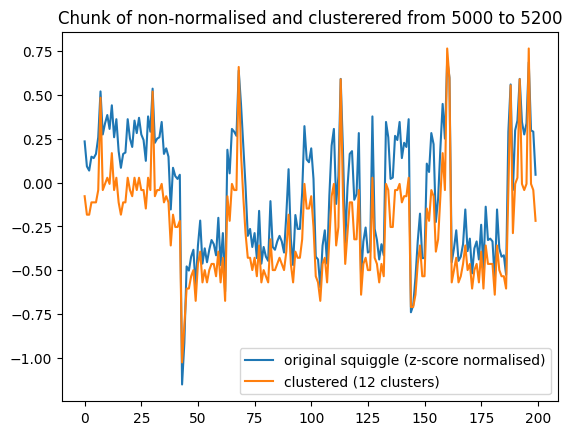

In [16]:
chunkStart = 5000
chunkEnd = chunkStart + 200

fig = plt.figure()
plt.title(f"Chunk of non-normalised and clusterered from {chunkStart} to {chunkEnd}")

plt.plot(zScoreNormalised[0][chunkStart:chunkEnd], label="original squiggle (z-score normalised)")
plt.plot(clusteredNormalised[0][chunkStart:chunkEnd], label=f"clustered ({noOfClusters} clusters)")
plt.legend()
plt.show()

#### Using the elbow method to determine optimal no. of clusters for given squiggle

1


/tmp/ipykernel_6178/340829258.py:5: RuntimeWarning: invalid value encountered in divide
  zScoreNormalised = (sequence - mean) / standardDev


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Took 968.0011286735535 seconds.



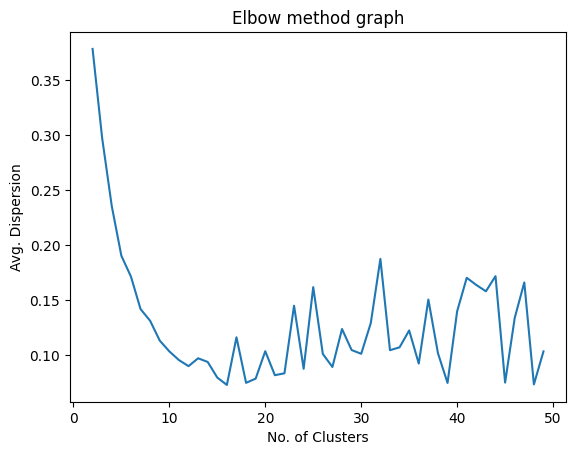

In [33]:
upperLimClusters = 50
avgDispersion = []
kValues = [i for i in range(1, upperLimClusters)]
start = time.time()
for i in kValues:
    print(i)
    clust = zScoreNormalise(clustNormalise(zScoreNormalised[0].tolist(), noOfClusters=i, verbose=False))
    
    dispersions = np.abs(zScoreNormalised[0] - clust)
    avgDispersion.append(np.mean(dispersions))
    
print(f"Took {time.time()-start} seconds.\n")

fig = plt.figure()
plt.title("Elbow method graph")

plt.plot(kValues, avgDispersion)
plt.xlabel("No. of Clusters")
plt.ylabel("Avg. Dispersion")
plt.show()

Here, we can see a great decrease in avg. dispersion between original data and clustered data up until around k=12 where the curve becomes non-monotonic.

The non-monotonicity of the curve is due to the non-determinism of the k-means clustering algorithm. Being more selective of the initial centroid positions will allow us to obtain a monotonically convergent curve for the elbow method. It does seem, however, that the elbow is around the point where the centroid initialisation problems occur.

## Based on significant changes in squiggle

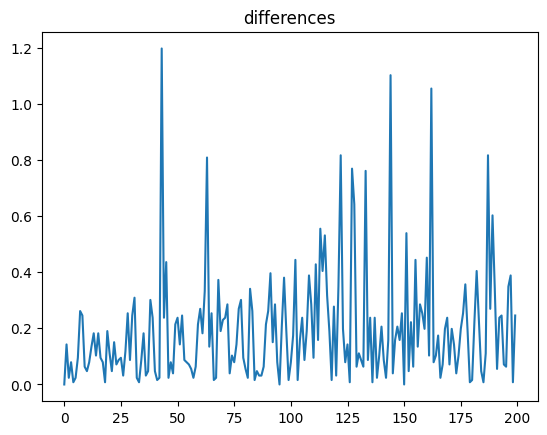

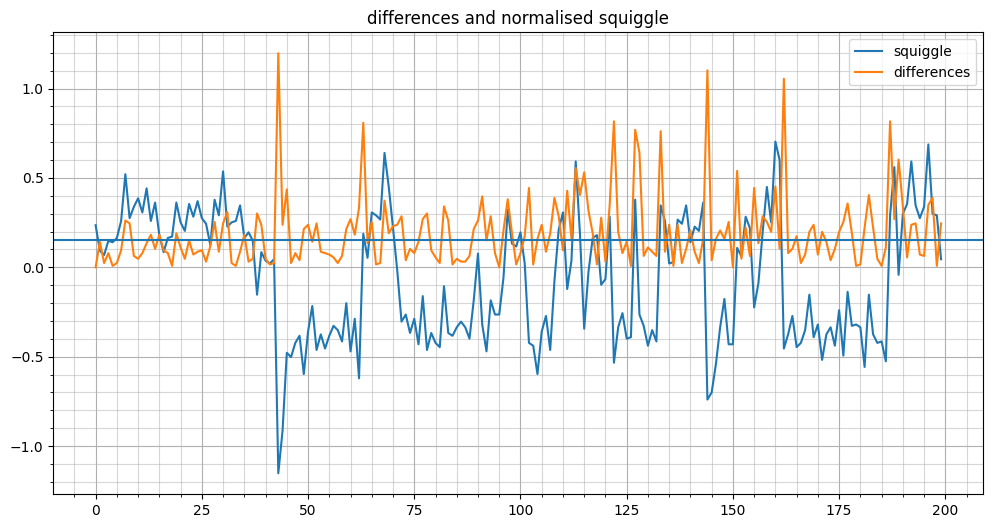

In [17]:
squiggleChunk = zScoreNormalised[0][chunkStart:chunkEnd]

# Initialize an empty list to store moving averages
differences = []

for i in range(len(squiggleChunk)-1):
	 differences.append(abs(squiggleChunk[i+1] - squiggleChunk[i]))

differences.insert(0, 0)		#inserting 0 at 0th index to compensate for shift
plt.title("differences")
plt.plot(differences)

# plotting

#max = 1000
#thresh = 0.15#0.0625+(0.0625*0.1)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("differences and normalised squiggle")
ax.plot(squiggleChunk, label="squiggle")
ax.plot(differences, label="differences")
ax.axhline(thresh)
ax.minorticks_on()
ax.grid(which = "minor", alpha = 0.5)
ax.grid()
ax.legend()

For each entry in the squiggle, if the difference is below the threshold, then just plot the last "significant value":

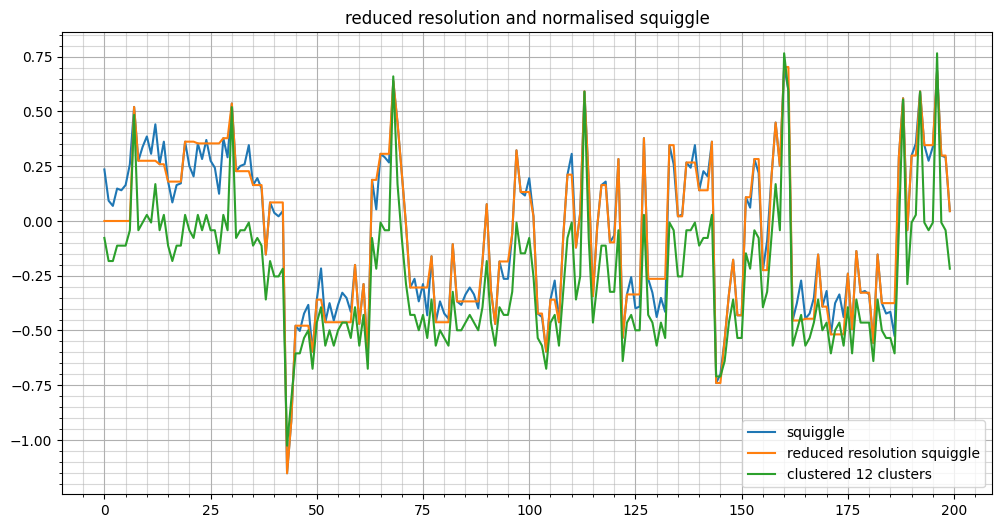

In [18]:
resReducedSquiggle = []
sig = 0
for i in range(len(squiggleChunk)):
    if differences[i] > thresh: sig = squiggleChunk[i]
    resReducedSquiggle.append(sig)


fig, ax = plt.subplots(figsize=(12, 6))
plt.title("reduced resolution and normalised squiggle")
ax.plot(squiggleChunk, label="squiggle")
ax.plot(resReducedSquiggle, label="reduced resolution squiggle")
ax.plot(clusteredNormalised[0][chunkStart:chunkEnd], label=f"clustered {noOfClusters} clusters")

ax.minorticks_on()
ax.grid(which = "minor", alpha = 0.5)
ax.grid()
ax.legend()